# Exploratory Data Analysis on the World Bank Data

The objective of this project is to collect data from the World Bank Open APIs and prepare and analyse the data using Python.

In [103]:
import pandas as pd
import numpy as np
import requests

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Task-1: Data Identification

For this analysis, the following API has been selected: https://datahelpdesk.worldbank.org/knowledgebase/articles/889392-api-documentation

The World Bank data consists of demographic and other statistical data related to Population, Employment, Health, GDP, Energy Consumption, etc. for all the countries from the year 1960 to 2018. These categories are called indicators and are each defined by a code.

The following indicators have been chosen for analysis:
* SP.POP.TOTL - Total Population
* SP.POP.TOTL.FE.IN - Total Female Population
* SP.POP.TOTL.MA.IN - Total Male Population
* SP.DYN.CBRT.IN Birth Rate
* SP.DYN.CDRT.IN Death Rate
* SE.COM.DURS - Compulsory Education Duration
* SL.IND.EMPL.ZS - Employment in Industry(%)
* SL.AGR.EMPL.ZS - Employment in Agriculture(%)
* SL.AGR.EMPL.FE.ZS - Female Employment in Agriculture(%)
* SL.IND.EMPL.FE.ZS - Female Employment in Industry(%)
* SL.UEM.TOTL.ZS - Unemployment(%)
* NY.GDP.MKTP.CD - GDP in USD
* NY.ADJ.NNTY.PC.KD.ZG - National Income per Capita
* NY.GSR.NFCY.CD - Net income from Abroad
* NV.AGR.TOTL.CD - Agriculture value added(in USD)
* EG.USE.ELEC.KH.PC - Electric Power Consumption(kWH per capita)
* EG.FEC.RNEW.ZS - Renewable Energy Consumption (%)
* EG.USE.COMM.FO.ZS - Fossil Fuel Consumption (%)
  
The following countries have been chosen for analysis:
* US - United States of America
* IN - India
* CN - China
* JP - Japan
* CA - Canada
* GB - Great Britain
* ZA - South Africa

The base API URL is http://api.worldbank.org/v2/ and is followed by the country code and indicator code to obtain the data for each year.
No authentication is required to use the API.

# Task-2: Data Collection

## Defining Constants

Since the API uses codes, we have created a mapping between the codes and meaningful names to use while parsing and storing the data. 

In [104]:
# Base URL used in all the API calls
BASE_URL='http://api.worldbank.org/v2/'

# List of indicators according to the features defined above
INDICATOR_CODES=['SP.POP.TOTL', 'SP.POP.TOTL.FE.IN', 'SP.POP.TOTL.MA.IN',
 'SP.DYN.CBRT.IN', 'SP.DYN.CDRT.IN',
 'SE.COM.DURS',
 'SL.IND.EMPL.ZS', 'SL.AGR.EMPL.ZS', 'SL.AGR.EMPL.FE.ZS', 'SL.IND.EMPL.FE.ZS', 'SL.UEM.TOTL.ZS',
 'NY.GDP.MKTP.CD',
 'NY.ADJ.NNTY.PC.KD.ZG', 'NY.GSR.NFCY.CD', 'NV.AGR.TOTL.CD',
 'EG.USE.ELEC.KH.PC', 'EG.FEC.RNEW.ZS', 'EG.USE.COMM.FO.ZS']

COUNTRY_LIST=['USA', 'India', 'China', 'Japan', 'Canada', 'Great Britain', 'South Africa']

# mapping of feature codes to more meaningful names
featureMap={
    "SP.POP.TOTL": "Total Population",
    "SP.POP.TOTL.FE.IN": "Female Population",
    "SP.POP.TOTL.MA.IN": "Male Population",
    "SP.DYN.CBRT.IN": "Birth Rate",
    "SP.DYN.CDRT.IN": "Death Rate",
    "SE.COM.DURS": "Compulsory Education Dur.",
    "SL.IND.EMPL.ZS":"Employment in Industry(%)",
    "SL.AGR.EMPL.ZS": "Employment in Agriculture(%)",
    "SL.AGR.EMPL.FE.ZS": "Female Employment in Agriculture(%)",
    "SL.IND.EMPL.FE.ZS": "Female Employment in Industry(%)",
    "SL.UEM.TOTL.ZS": "Unemployment(%)",
    "NY.GDP.MKTP.CD": "GDP in USD",
    "NY.ADJ.NNTY.PC.KD.ZG":"National Income per Capita",
    "NY.GSR.NFCY.CD":"Net income from Abroad",
    "NV.AGR.TOTL.CD":"Agriculture value added(in USD)",
    "EG.USE.ELEC.KH.PC":"Electric Power Consumption(kWH per capita)",
    "EG.FEC.RNEW.ZS":"Renewable Energy Consumption (%)",
    "EG.USE.COMM.FO.ZS":"Fossil Fuel Consumption (%)"
}

# Mapping of country codes to their actual names
countryMap={
    "US": "USA",
    "IN":"India",
    "CN": "China",
    "JP": "Japan",
    "CA": "Canada",
    "GB": "Great Britain",
    "ZA": "South Africa"
}

# constant parameters used in sending the request.
params = dict()
# to ensure we receive a JSON response
params['format']='json'
# The data we fetch is for 59 years.
# Hence we change the default page size of 50 to 100 to ensure we need only one API call per feature.
params['per_page']='100'
# Range of years for which the data is needed
params['date']='1960:2018'

## Fetch data through API calls
    
The following functions have been written to make an API call per feature and fetch the data. Each of these functions performs the following tasks:

* **getCountrywiseDF():** Calls the loadJSONData function for the country specified and returns a dataframe with the complete data for one country.
* **loadJSONData():** Forms the appropriate URL using the base URL, country code and indicator code and sends the request to the endpoint. It returns a list of list of values for all features.

In [105]:
# Function to get JSON data from the endpoint
def loadJSONData(country_code): 
    dataList=[]
    
    # iterate over each indicator code specified in the contant INDICATOR_CODES defined above
    for indicator in INDICATOR_CODES: 
        
        # form the URL in the desired format
        # E.g: http://api.worldbank.org/v2/countries/us/indicators/SP.POP.TOTL?format=json&per_page=200&date=1960:2018
        url=BASE_URL+'countries/'+country_code.lower()+'/indicators/'+indicator
        
        # send the request using the resquests module
        response = requests.get(url, params=params)
        
        # validate the response status code
        # The API returns a status_code 200 even for error messages,
        # however, the response body contains a field called "message" that includes the details of the error
        # check if message is not present in the response
        if response.status_code == 200 and ("message" not in response.json()[0].keys()):
            # print("Successfully got data for: " + str(featureMap[indicator]))
            
            # list of values for one feature
            indicatorVals=[]
            
            # the response is an array containing two arrays - [[{page: 1, ...}], [{year: 2018, SP.POP.TOTL: 123455}, ...]]
            # hence we check if the length of the response is >1
            if len(response.json()) > 1:
                
                # if yes, iterate over each object in the response
                # each object gives one single value for each year
                for obj in response.json()[1]:
                    
                    # check for empty values
                    if obj['value'] is "" or obj['value'] is None:
                        indicatorVals.append(None)
                    else:
                    # if a value is present, add it to the list of indicator values
                        indicatorVals.append(float(obj['value']))
                dataList.append(indicatorVals)
        else:
            # print an error message if the API call failed
            print("Error in Loading the data. Status Code: " + str(response.status_code))
            
    # Once all the features have been obtained, add the values for the "Year"
    # The API returns the indicator values from the most recent year. Hence, we create a list of years in reverse order
    dataList.append([year for year in range(2018, 1959, -1)])
    # return the list of lists of feature values [[val1,val2,val3...], [val1,val2,val3...], [val1,val2,val3...], ...]
    return dataList

#----------------------------------------------------------------------------------------------------

# function to invokde the loadJSONData function and form the final DataFrame for each country
def getCountrywiseDF(country_code):
    
    # The resulting dataframe needs to have meaningful column names
    # hence we create a list of column names from the map defined above
    col_list=list(featureMap.values())
    # append the year column name
    col_list.append('Year')
    
    print("------------------Loading data for: "+countryMap[country_code]+"-----------------------")
    
    # for the given country call the loadJSONData function and fetch the data from the API
    dataList=loadJSONData(country_code)
    
    # transform the list of lists of features into a DataFrame
    # np.column_stack is used to add each list as a column 
    df=pd.DataFrame(np.column_stack(dataList), columns=col_list)
    
    # add the country column by extracting the country name from the map using the country code
    df['Country'] = countryMap[country_code]
    
    # display the resulting dataframe
    display(df.head())
    
    # return the formed dataframe for the given country
    return df

In [106]:
# Call the getCountrywiseDF function with the code of each country under consideration
# We will have a seperate dataframe for each country - 7 data frames

US_df=getCountrywiseDF('US')
IN_df=getCountrywiseDF('IN')
CN_df=getCountrywiseDF('CN')
JP_df=getCountrywiseDF('JP')
CA_df=getCountrywiseDF('CA')
GB_df=getCountrywiseDF('GB')
ZA_df=getCountrywiseDF('ZA')

print("Data Loading Completed")

------------------Loading data for: USA-----------------------


,Total Population,Female Population,Male Population,Birth Rate,Death Rate,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Female Employment in Agriculture(%),Female Employment in Industry(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Agriculture value added(in USD),Electric Power Consumption(kWH per capita),Renewable Energy Consumption (%),Fossil Fuel Consumption (%),Year,Country
0,"327,167,434.0","165,285,036.0","161,882,398.0",None,None,12.0,19.4,1.4,0.8,8.5,3.9,"20,544,343,456,936.5",None,"267,900,000,000.0",None,None,None,None,2018,USA
1,"325,147,121.0","164,275,323.0","160,871,798.0",11.8,8.5,12.0,19.7,1.4,0.8,8.7,4.4,"19,485,393,853,000.0",2.2,"243,296,000,000.0","178,579,605,000.0",None,None,None,2017,USA
2,"323,071,342.0","163,245,729.0","159,825,613.0",12.2,8.5,12.0,19.8,1.4,0.8,8.7,4.9,"18,707,188,235,000.0",-0.1,"218,168,000,000.0","175,923,170,000.0",None,None,None,2016,USA
3,"320,742,673.0","162,097,641.0","158,645,032.0",12.4,8.4,12.0,19.9,1.4,0.7,8.8,5.3,"18,219,297,584,000.0",2.4,"224,626,000,000.0","189,947,276,000.0",None,8.7,82.4,2015,USA
4,"318,386,421.0","160,946,480.0","157,439,941.0",12.5,8.2,12.0,20.0,1.4,0.7,8.9,6.2,"17,521,746,534,000.0",2.9,"241,062,000,000.0","208,273,224,000.0","12,994.0",8.8,83.1,2014,USA


------------------Loading data for: India-----------------------


,Total Population,Female Population,Male Population,Birth Rate,Death Rate,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Female Employment in Agriculture(%),Female Employment in Industry(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Agriculture value added(in USD),Electric Power Consumption(kWH per capita),Renewable Energy Consumption (%),Fossil Fuel Consumption (%),Year,Country
0,"1,352,617,328.0","649,574,719.0","703,042,609.0",None,None,8.0,24.7,43.9,57.1,18.7,2.6,"2,718,732,231,257.6",None,"-27,691,371,968.3","396,987,486,510.1",None,None,None,2018,India
1,"1,338,658,835.0","642,787,641.0","695,871,194.0",18.1,7.2,8.0,24.5,44.5,57.6,18.7,2.6,"2,652,242,857,923.9",4.0,"-28,673,153,563.2","414,265,878,403.3",None,None,None,2017,India
2,"1,324,509,589.0","635,908,885.0","688,600,704.0",18.3,7.2,8.0,24.3,45.1,58.2,18.6,2.7,"2,290,432,075,123.8",6.4,"-26,300,115,592.2","372,190,852,855.1",None,None,None,2016,India
3,"1,310,152,403.0","628,929,065.0","681,223,338.0",18.6,7.2,8.0,24.3,45.6,58.6,18.7,2.8,"2,103,587,813,812.8",7.6,"-24,405,488,068.3","340,244,981,475.1",None,36.0,None,2015,India
4,"1,295,604,184.0","621,854,638.0","673,749,546.0",19.0,7.2,8.0,24.4,46.1,59.1,18.7,2.8,"2,039,127,446,298.6",5.8,"-24,112,069,639.3","342,408,945,451.4",804.5,36.7,73.6,2014,India


------------------Loading data for: China-----------------------


,Total Population,Female Population,Male Population,Birth Rate,Death Rate,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Female Employment in Agriculture(%),Female Employment in Industry(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Agriculture value added(in USD),Electric Power Consumption(kWH per capita),Renewable Energy Consumption (%),Fossil Fuel Consumption (%),Year,Country
0,"1,392,730,000.0","677,972,245.0","714,757,755.0",None,None,9.0,28.6,26.8,24.2,28.3,4.4,"13,608,151,864,637.9",None,"-51,298,699,628.7","978,452,524,165.8",None,None,None,2018,China
1,"1,386,395,000.0","674,707,818.0","711,687,182.0",12.4,7.1,9.0,29.0,27.0,24.4,28.8,4.4,"12,143,491,448,186.1",4.8,"-9,688,110,315.4","918,794,756,465.6",None,None,None,2017,China
2,"1,378,665,000.0","670,780,903.0","707,884,097.0",12.9,7.1,9.0,29.1,27.7,25.1,29.1,4.5,"11,137,945,669,350.6",7.5,"-44,951,463,616.5","905,097,449,018.0",None,None,None,2016,China
3,"1,371,220,000.0","667,009,225.0","704,210,775.0",12.1,7.1,9.0,29.2,28.6,26.0,29.3,4.6,"11,015,542,352,468.9",7.4,"-41,788,839,823.4","927,733,440,385.4",None,12.4,None,2015,China
4,"1,364,270,000.0","663,493,378.0","700,776,622.0",12.4,7.2,9.0,29.4,29.5,26.8,29.7,4.6,"10,438,529,153,237.6",7.2,"13,298,824,755.0","905,464,400,820.4","3,927.0",12.2,87.7,2014,China


------------------Loading data for: Japan-----------------------


,Total Population,Female Population,Male Population,Birth Rate,Death Rate,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Female Employment in Agriculture(%),Female Employment in Industry(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Agriculture value added(in USD),Electric Power Consumption(kWH per capita),Renewable Energy Consumption (%),Fossil Fuel Consumption (%),Year,Country
0,"126,529,100.0","64,731,350.0","61,797,750.0",None,None,9.0,24.5,3.4,3.0,14.0,2.4,"4,971,323,079,771.9",None,None,None,None,None,None,2018,Japan
1,"126,785,797.0","64,853,783.0","61,932,014.0",7.6,10.8,9.0,24.6,3.4,3.0,14.1,2.8,"4,859,950,558,539.0",1.4,"177,764,874,566.3","57,797,299,055.4",None,None,None,2017,Japan
2,"126,994,511.0","64,951,468.0","62,043,043.0",7.8,10.5,9.0,25.6,3.5,3.0,14.5,3.1,"4,926,667,087,367.5",1.5,"165,257,107,699.7","59,665,658,303.1",None,None,None,2016,Japan
3,"127,141,000.0","65,016,722.0","62,124,278.0",8.0,10.3,9.0,25.9,3.6,3.2,14.8,3.4,"4,389,475,622,589.0",4.1,"168,614,682,836.8","48,894,606,458.7",None,6.3,93.0,2015,Japan
4,"127,276,000.0","65,075,452.0","62,200,548.0",8.0,10.1,9.0,26.0,3.7,3.3,14.7,3.6,"4,850,413,536,037.8",0.5,"174,559,801,997.8","51,233,292,919.4","7,819.7",5.6,94.4,2014,Japan


------------------Loading data for: Canada-----------------------


,Total Population,Female Population,Male Population,Birth Rate,Death Rate,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Female Employment in Agriculture(%),Female Employment in Industry(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Agriculture value added(in USD),Electric Power Consumption(kWH per capita),Renewable Energy Consumption (%),Fossil Fuel Consumption (%),Year,Country
0,"37,058,856.0","18,674,525.0","18,384,331.0",None,None,10.0,19.5,1.5,0.9,8.4,5.9,"1,713,341,704,877.0",None,"-22,155,520,038.5",None,None,None,None,2018,Canada
1,"36,540,268.0","18,417,231.0","18,123,037.0",10.3,7.5,10.0,19.5,1.5,1.0,8.5,6.3,"1,646,867,220,617.5",3.9,"-19,163,504,935.8",None,None,None,None,2017,Canada
2,"36,109,487.0","18,202,997.0","17,906,490.0",10.6,7.4,10.0,19.6,1.9,1.1,8.5,7.0,"1,526,705,529,135.3",-0.3,"-18,668,313,909.5",None,None,None,None,2016,Canada
3,"35,702,908.0","17,999,309.0","17,703,599.0",10.7,7.4,10.0,19.9,1.6,1.0,8.5,6.9,"1,552,899,925,233.7",-2.9,"-23,844,486,211.7","26,575,200,689.3",None,22.0,74.1,2015,Canada
4,"35,437,435.0","17,864,828.0","17,572,607.0",10.8,7.3,10.0,20.2,1.7,1.1,8.6,6.9,"1,801,480,123,070.8",1.4,"-29,178,622,922.1","25,667,412,178.7","15,588.5",22.0,73.2,2014,Canada


------------------Loading data for: Great Britain-----------------------


,Total Population,Female Population,Male Population,Birth Rate,Death Rate,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Female Employment in Agriculture(%),Female Employment in Industry(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Agriculture value added(in USD),Electric Power Consumption(kWH per capita),Renewable Energy Consumption (%),Fossil Fuel Consumption (%),Year,Country
0,"66,488,991.0","33,666,883.0","32,822,108.0",None,None,11.0,18.1,1.1,0.6,7.6,4.0,"2,855,296,731,522.0",None,"-38,490,804,137.5","18,020,718,920.3",None,None,None,2018,Great Britain
1,"66,058,859.0","33,464,674.0","32,594,185.0",11.4,9.2,11.0,18.2,1.2,0.6,7.7,4.3,"2,666,229,179,958.0",1.9,"-31,787,538,497.2","17,431,087,145.4",None,None,None,2017,Great Britain
2,"65,595,565.0","33,246,523.0","32,349,042.0",11.8,9.1,11.0,18.5,1.1,0.6,7.6,4.8,"2,694,283,209,613.3",1.0,"-64,716,135,083.3","16,288,737,010.4",None,None,None,2016,Great Britain
3,"65,128,861.0","33,027,804.0","32,101,057.0",11.9,9.2,11.0,18.7,1.1,0.6,7.7,5.3,"2,928,591,002,002.5",2.0,"-66,997,636,392.8","18,200,415,988.6",None,8.7,80.4,2015,Great Britain
4,"64,613,160.0","32,785,655.0","31,827,505.0",12.0,8.8,11.0,19.0,1.3,0.7,7.9,6.1,"3,063,803,240,208.0",2.7,"-62,560,715,026.0","20,435,074,169.1","5,129.5",7.4,82.7,2014,Great Britain


------------------Loading data for: South Africa-----------------------


,Total Population,Female Population,Male Population,Birth Rate,Death Rate,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Female Employment in Agriculture(%),Female Employment in Industry(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Agriculture value added(in USD),Electric Power Consumption(kWH per capita),Renewable Energy Consumption (%),Fossil Fuel Consumption (%),Year,Country
0,"57,779,622.0","29,290,888.0","28,488,734.0",None,None,9.0,23.2,5.2,3.7,12.1,27.0,"368,288,939,768.3",None,"-11,640,181,654.7","8,014,039,701.1",None,None,None,2018,South Africa
1,"57,000,451.0","28,883,601.0","28,116,850.0",20.9,9.5,9.0,23.3,5.2,3.7,12.2,27.3,"349,554,116,683.8",0.8,"-10,483,365,758.0","8,253,798,946.9",None,None,None,2017,South Africa
2,"56,203,654.0","28,469,912.0","27,733,742.0",21.3,9.6,9.0,23.3,5.6,3.9,11.9,26.6,"296,357,282,715.1",-1.7,"-8,190,335,037.5","6,591,156,314.6",None,None,None,2016,South Africa
3,"55,386,367.0","28,049,364.0","27,337,003.0",21.7,9.8,9.0,23.8,5.6,4.2,11.8,25.2,"317,620,522,794.8",2.3,"-7,871,410,981.4","6,634,302,430.5",None,17.2,None,2015,South Africa
4,"54,545,991.0","27,621,049.0","26,924,942.0",22.1,10.0,9.0,23.4,4.7,3.2,12.1,24.9,"350,904,575,292.3",0.5,"-9,363,726,900.5","7,631,145,522.1","4,197.9",16.6,86.8,2014,South Africa


Data Loading Completed


# Task-3: Data Pre-processing

The above data has just been collected through multiple API calls and combined together. As we can see from the dataframes that we created by fetching the features from the API calls, contain some missing values in some of the features. This means that the data needs some processing before using it for analysis.

For easing the task of pre-processing and avoiding manually passing the dataframes to each of the following functions, we create a list of the dataframes created. The copy() method has been used to avoid changing the original unprocessed dataframes.

In [107]:
# store all the DataFrames in a list to iteratively apply pre-processing steps
list_df=[US_df.copy(), IN_df.copy(), CN_df.copy(), JP_df.copy(), CA_df.copy(), GB_df.copy(), ZA_df.copy()]

## Drop features with majority values missing

We need to identify the features with a large number of missing values. Such features are not useful for analysis and can be removed from the dataset.
The following function has been implemented to perform this task.

* **remove_missing_features():** This function takes a dataframe as a parameter. It finds the features that contain non-zero missing values. It then finds the percentage of missing values in each of the columns. The percentage of missing values is checked and if it is greater than 75%, the column is dropped from the dataframe and an updated dataframe is returned. If a column has more than 75% missing values it is absolutely not useful for analysis. This function is iteratively called on all of the dataframes created above.

In [108]:
# Function to identify missing features and remove features that aren't useful

def remove_missing_features(df):
    
    # validation for dataframe
    if df is None:
        print("No DataFrame received!")
        return
    
    # create a copy of the dataframe to avoid changing the original
    df_cp=df.copy()
    
    print("Removing missing features for: " + df_cp.iloc[0]['Country'])
    
    # find features with non-zero missing values
    n_missing_vals=df.isnull().sum()

    # get the index list of the features with non-zero missing values
    n_missing_index_list = list(n_missing_vals.index)
    
    # calculate the percentage of missing values
    # shape[0] gives the number of rows in the dataframe, hence, by diving the no. number of missing values by the total
    # no. of rows we get the ratio of missing values - multipled by 100 to get percentage
    # here missing_percentage consists of key value pairs - column name: percentage of missing values
    missing_percentage = n_missing_vals[n_missing_vals!=0]/df.shape[0]*100
    
    '''
    Example: missing_percentage
    Total Population 1.694915254237288
    Female Population 1.694915254237288
    Male Population 83.05084745762711
    Birth Rate 52.54237288135594
    '''

    # list to maintain the columns to drop
    cols_to_trim=[]
    
    # iterate over each key value pair
    for i,val in enumerate(missing_percentage):
        # if percentage value is > 75
        if val > 75:
            # add the corresponding column to the list of cols_to_trim
            cols_to_trim.append(n_missing_index_list[i])

    # Example: cols_to_trim=['Male Population']

    if len(cols_to_trim) > 0:
        # drop the columns identified using the dataframe drop() method
        df_cp=df_cp.drop(columns=cols_to_trim)
        print("Dropped Columns:" + str(cols_to_trim))
    else:
        print("No columns dropped")

    # return the updated dataframe
    return df_cp

In [109]:
# call the function on each DF for each country.
# The function remove_missing_features will be applied on each dataframe in list_df through the map function in python.
list_df=list(map(remove_missing_features, list_df))

Removing missing features for: USA
No columns dropped
Removing missing features for: India
Dropped Columns:['Male Population']
Removing missing features for: China
No columns dropped
Removing missing features for: Japan
No columns dropped
Removing missing features for: Canada
No columns dropped
Removing missing features for: Great Britain
No columns dropped
Removing missing features for: South Africa
No columns dropped


We can see that the only column dropped was Male population from the country India.
For rest of the countries, all the features consisted of less than 75% missing values. So far we have only removed features that had missing values greater than a certain threshold. This means that, some features may still contain missing values. The next task is to fill these missing values so that they can be used in analysis.

##  Fill missing values

The following function has been implemented to fill the missing values in features:
* **fill_missing_values():** This function takes a dataframe in which the missing values need to be filled. It uses the *fillna()* function of pandas dataframes to fill values that are NaNs. As observed from the raw dataframes populated above, the missing values are denoted by None. Hence we first fill NaN in place of None and then replace the NaNs with the mean value of the columns.

In [110]:
# Function to fill the remaining missing values with average values for columns

def fill_missing_values(df):
    
    # validation for dataframes
    if df is None:
        print("No DataFrame received")
        return

    # create a copy
    df_cp=df.copy()
    
    print("Filling missing features for: " + df_cp.iloc[0]['Country'])
    
    # get the list of columns in the dataframe
    cols_list=list(df_cp.columns)
    
    # exclude the last column - Country
    # This column was added explicitly when the data was loaded, hence, it does not contain any missing values.
    # Also, fillna function does not work on categorical features since it performs an aggregation.
    cols_list.pop()
    
    # replace all None values with NaN, fillna only works on nans
    df_cp.fillna(value=pd.np.nan, inplace=True)
    
    # replace all NaN values with the mean of the column values
    for col in cols_list:
        df_cp[col].fillna((df_cp[col].mean()), inplace=True)

    print("Filling missing values completed")
    return df_cp

In [111]:
# call the function on each DF for each country.
# The function fill_missing_features will be applied on each dataframe in list_df through the map function in python.

list_df=list(map(fill_missing_values, list_df))

Filling missing features for: USA
Filling missing values completed
Filling missing features for: India
Filling missing values completed
Filling missing features for: China
Filling missing values completed
Filling missing features for: Japan
Filling missing values completed
Filling missing features for: Canada
Filling missing values completed
Filling missing features for: Great Britain
Filling missing values completed
Filling missing features for: South Africa
Filling missing values completed


## Change the type of Numeric but Categorical Features

We can observe that the 'Year' column is a numeric value, however, it's magnitude does not have a significance. It actually represents a period and not an actual number. Hence, this column can be converted to a categorical variable.
The following function has been implemented to achieve this:

* **change_year_type():** This function takes a dataframe as a parameter and changes the dtype of year and returns the updated dataframe

In [112]:
# Function to change year type
def change_year_type(df):
    
    print("Changing type of Year for: " + df.loc[0]['Country'])
    # validation to check if year column exists in the dataframe
    if 'Year' in df.columns:
        # convert year to a string
        df['Year'] = df.Year.astype(str)
    
    print("Completed changing type")
    # return the updated df
    return df

In [113]:
# call the function on each DF for each country.
# The function fill_missing_features will be applied on each dataframe in list_df through the map function in python.

list_df=list(map(change_year_type, list_df))

Changing type of Year for: USA
Completed changing type
Changing type of Year for: India
Completed changing type
Changing type of Year for: China
Completed changing type
Changing type of Year for: Japan
Completed changing type
Changing type of Year for: Canada
Completed changing type
Changing type of Year for: Great Britain
Completed changing type
Changing type of Year for: South Africa
Completed changing type


## Derive deleted features

In one of the above steps, we can see that the column **Male Population** from the DF for country **India** was dropped since it had too many missing values. This feature may be useful in further analysis. Also, since rest of the DataFrames contain this column, to maintain consistency, we can derive this feature from Total Population and Female population. 

In [114]:
# pick the dataframe for the country India from the list of dataframes
dfIndia = list_df[1]

# Male Population in any given year=Total Population - Female Population
# validation so that the operation does not fail
if 'Total Population' in dfIndia.columns and 'Female Population' in dfIndia.columns:
    # calculate
    dfIndia["Male Population"] = dfIndia["Total Population"] - dfIndia["Female Population"]
else:
    # print error message
    print("One of the columns Total Population or Female Population is missing.")

list_df[1].head()

,Total Population,Female Population,Birth Rate,Death Rate,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Female Employment in Agriculture(%),Female Employment in Industry(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Agriculture value added(in USD),Electric Power Consumption(kWH per capita),Renewable Energy Consumption (%),Fossil Fuel Consumption (%),Year,Country,Male Population
0,"1,352,617,328.0","649,574,719.0",31.3,12.3,8.0,24.7,43.9,57.1,18.7,2.6,"2,718,732,231,257.6",3.5,"-27,691,371,968.3","396,987,486,510.1",335.2,48.4,54.7,2018,India,"703,042,609.0"
1,"1,338,658,835.0","642,787,641.0",18.1,7.2,8.0,24.5,44.5,57.6,18.7,2.6,"2,652,242,857,923.9",4.0,"-28,673,153,563.2","414,265,878,403.3",335.2,48.4,54.7,2017,India,"695,871,194.0"
2,"1,324,509,589.0","635,908,885.0",18.3,7.2,8.0,24.3,45.1,58.2,18.6,2.7,"2,290,432,075,123.8",6.4,"-26,300,115,592.2","372,190,852,855.1",335.2,48.4,54.7,2016,India,"688,600,704.0"
3,"1,310,152,403.0","628,929,065.0",18.6,7.2,8.0,24.3,45.6,58.6,18.7,2.8,"2,103,587,813,812.8",7.6,"-24,405,488,068.3","340,244,981,475.1",335.2,36.0,54.7,2015,India,"681,223,338.0"
4,"1,295,604,184.0","621,854,638.0",19.0,7.2,8.0,24.4,46.1,59.1,18.7,2.8,"2,039,127,446,298.6",5.8,"-24,112,069,639.3","342,408,945,451.4",804.5,36.7,73.6,2014,India,"673,749,546.0"


We have now completed all our preprocessing steps and have 7 dataframes for the 7 countries under consideration. Let us now examine the number of features and and their datatypes

## Check the number of features

In [115]:
# each dataframe has the same number of columns. Hence, we only check the first dataframe in the list

print('Total number of features: %d\n'%(list_df[0].shape[1]))
list_df[0].dtypes

Total number of features: 20



Total Population                              float64
Female Population                             float64
Male Population                               float64
Birth Rate                                    float64
Death Rate                                    float64
Compulsory Education Dur.                     float64
Employment in Industry(%)                     float64
Employment in Agriculture(%)                  float64
Female Employment in Agriculture(%)           float64
Female Employment in Industry(%)              float64
Unemployment(%)                               float64
GDP in USD                                    float64
National Income per Capita                    float64
Net income from Abroad                        float64
Agriculture value added(in USD)               float64
Electric Power Consumption(kWH per capita)    float64
Renewable Energy Consumption (%)              float64
Fossil Fuel Consumption (%)                   float64
Year                        

We now have a total of 20 features to work on. We can see that all of the features are numeric except for Year and Country which are categorical

## Store the cleaned dataset into CSV files

The dataframes for the 7 countries are stored into different CSV files for further analysis. The following function has been implemented for this task:
* **write_data():** Iterates over the list of dataframes and writes them to CSV files with the name of the country. For example, the file containing data for India is stored in the file India.csv

In [116]:
# Function to write processed data to CSV files
def write_data():
    # validation to check if the number of countries and the dataframes match
    assert len(list(countryMap.keys()))==len(list_df)
    
    # iterate over country names from the country map and the list of dataframes simultaneously
    for country_name, df_data in zip(COUNTRY_LIST, list_df):
        print("Writing data for: " + country_name)
        file_name=country_name+".csv"
        # convert to CSV
        try:
            df_data.to_csv(file_name, index=False)
            print("Successfully created: " + file_name)
        except:
            # in case an error occurs in I/O
            print("Error in writing to: " + file_name)
        
        # Note that the order in which the countries have been maintained in the country_list
        # and the order in which they have been maintained is the same

In [117]:
# call the function
write_data()

Writing data for: USA
Successfully created: USA.csv
Writing data for: India
Successfully created: India.csv
Writing data for: China
Successfully created: China.csv
Writing data for: Japan
Successfully created: Japan.csv
Writing data for: Canada
Successfully created: Canada.csv
Writing data for: Great Britain
Successfully created: Great Britain.csv
Writing data for: South Africa
Successfully created: South Africa.csv


# Task 5: Analyse and Summarise the cleaned dataset

Since we have all the pre-processed datasets, we can create visualisations from them to identify patterns. I have used the **matplotlib** and **seaborn** libraries to analyse the data.

## Read the cleaned data from the CSV files

We can now use the cleaned dataset for analysis. Hence we first read the CSV files we created in the previous task.

In [118]:
# read the cleaned data from every CSV
try:
    df_cleaned_us=pd.read_csv('USA.csv')
    df_cleaned_in=pd.read_csv('India.csv')
    df_cleaned_cn=pd.read_csv('China.csv')
    df_cleaned_jp=pd.read_csv('Japan.csv')
    df_cleaned_ca=pd.read_csv('Canada.csv')
    df_cleaned_gb=pd.read_csv('Great Britain.csv')
    df_cleaned_za=pd.read_csv('South Africa.csv')
    print("Successfully read all the files")
except:
    # handling I/O exceptions
    print("Unexpected error in reading a file. Check the file path and if a file exists with the name given.")

# display data of one country to check if the cleaned data is loaded
print("Displaying data for USA: ")
display(df_cleaned_us.head())

# create a list of clean dataframes for further analysis
list_cleaned_df=[df_cleaned_us, df_cleaned_in, df_cleaned_cn, df_cleaned_jp, df_cleaned_ca, df_cleaned_gb, df_cleaned_za]

Successfully read all the files
Displaying data for USA: 


,Total Population,Female Population,Male Population,Birth Rate,Death Rate,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Female Employment in Agriculture(%),Female Employment in Industry(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Agriculture value added(in USD),Electric Power Consumption(kWH per capita),Renewable Energy Consumption (%),Fossil Fuel Consumption (%),Year,Country
0,"327,167,434.0","165,285,036.0","161,882,398.0",15.7,8.7,12.0,19.4,1.4,0.8,8.5,3.9,"20,544,343,456,936.5",1.7,"267,900,000,000.0","152,778,873,809.5","10,318.0",6.0,89.3,2018,USA
1,"325,147,121.0","164,275,323.0","160,871,798.0",11.8,8.5,12.0,19.7,1.4,0.8,8.7,4.4,"19,485,393,853,000.0",2.2,"243,296,000,000.0","178,579,605,000.0","10,318.0",6.0,89.3,2017,USA
2,"323,071,342.0","163,245,729.0","159,825,613.0",12.2,8.5,12.0,19.8,1.4,0.8,8.7,4.9,"18,707,188,235,000.0",-0.1,"218,168,000,000.0","175,923,170,000.0","10,318.0",6.0,89.3,2016,USA
3,"320,742,673.0","162,097,641.0","158,645,032.0",12.4,8.4,12.0,19.9,1.4,0.7,8.8,5.3,"18,219,297,584,000.0",2.4,"224,626,000,000.0","189,947,276,000.0","10,318.0",8.7,82.4,2015,USA
4,"318,386,421.0","160,946,480.0","157,439,941.0",12.5,8.2,12.0,20.0,1.4,0.7,8.9,6.2,"17,521,746,534,000.0",2.9,"241,062,000,000.0","208,273,224,000.0","12,994.0",8.8,83.1,2014,USA


## Prepare a combined DataFrame for further analysis

For each country, separate dataframes have been created. There may be cases when we may need the entire data across all countries in certain analysis. Hence it is a good idea to have a single combined dataframe ready.

In [119]:
combined_df=pd.concat(list_cleaned_df,sort=False)
combined_df.head(200)

,Total Population,Female Population,Male Population,Birth Rate,Death Rate,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Female Employment in Agriculture(%),Female Employment in Industry(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Agriculture value added(in USD),Electric Power Consumption(kWH per capita),Renewable Energy Consumption (%),Fossil Fuel Consumption (%),Year,Country
0,"327,167,434.0","165,285,036.0","161,882,398.0",15.7,8.7,12.0,19.4,1.4,0.8,8.5,3.9,"20,544,343,456,936.5",1.7,"267,900,000,000.0","152,778,873,809.5","10,318.0",6.0,89.3,2018,USA
1,"325,147,121.0","164,275,323.0","160,871,798.0",11.8,8.5,12.0,19.7,1.4,0.8,8.7,4.4,"19,485,393,853,000.0",2.2,"243,296,000,000.0","178,579,605,000.0","10,318.0",6.0,89.3,2017,USA
2,"323,071,342.0","163,245,729.0","159,825,613.0",12.2,8.5,12.0,19.8,1.4,0.8,8.7,4.9,"18,707,188,235,000.0",-0.1,"218,168,000,000.0","175,923,170,000.0","10,318.0",6.0,89.3,2016,USA
3,"320,742,673.0","162,097,641.0","158,645,032.0",12.4,8.4,12.0,19.9,1.4,0.7,8.8,5.3,"18,219,297,584,000.0",2.4,"224,626,000,000.0","189,947,276,000.0","10,318.0",8.7,82.4,2015,USA
4,"318,386,421.0","160,946,480.0","157,439,941.0",12.5,8.2,12.0,20.0,1.4,0.7,8.9,6.2,"17,521,746,534,000.0",2.9,"241,062,000,000.0","208,273,224,000.0","12,994.0",8.8,83.1,2014,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,"126,843,000.0","64,552,936.0","62,290,064.0",9.4,7.7,9.0,31.4,5.1,5.5,21.6,4.7,"4,887,519,660,744.9",2.5,"69,818,262,802.1","75,072,263,386.7","8,299.4",3.9,80.7,2000,Japan
19,"126,631,000.0","64,416,945.0","62,214,055.0",9.3,7.8,9.0,31.9,5.2,5.8,22.1,4.7,"4,562,078,822,335.5",-0.8,"54,865,030,007.0","73,017,589,819.0","8,147.4",3.8,80.6,1999,Japan
20,"126,400,000.0","64,270,952.0","62,129,048.0",9.6,7.5,9.0,32.2,5.3,6.0,22.8,4.1,"4,032,509,760,872.9",-1.9,"48,839,122,632.9","65,831,559,150.0","8,004.0",4.0,79.4,1998,Japan
21,"126,057,000.0","64,068,675.0","61,988,325.0",9.5,7.3,9.0,33.3,5.4,6.0,24.2,3.4,"4,414,732,843,544.4",-0.0,"56,500,943,459.4","68,751,451,555.4","7,991.0",4.1,80.4,1997,Japan


## Descriptive Statistics

We can now analyse the data we have loaded. Descriptive statistics show the characteristics of numerical features. It gives information such as count, mean, mininum and maximum values etc. Hence we exclude the categorical features Year and Country from the combined DataFrame.

In [120]:
# create a copy so that the original DF is not affected
# drop the columns year and country
df_copy=combined_df.drop(['Year', 'Country'], axis='columns')
df_copy.describe()

,Total Population,Female Population,Male Population,Birth Rate,Death Rate,Compulsory Education Dur.,Employment in Industry(%),Employment in Agriculture(%),Female Employment in Agriculture(%),Female Employment in Industry(%),Unemployment(%),GDP in USD,National Income per Capita,Net income from Abroad,Agriculture value added(in USD),Electric Power Consumption(kWH per capita),Renewable Energy Consumption (%),Fossil Fuel Consumption (%)
count,413.0,413.0,413.0,413.0,413.0,413.0,413.0,413.0,413.0,413.0,413.0,413.0,413.0,413.0,413.0,413.0,413.0,413.0
mean,"349,611,508.7","170,880,636.9","178,730,871.8",19.9,9.4,9.7,24.1,16.6,17.7,15.4,8.4,"2,100,409,242,193.0",2.9,"12,542,248,900.4","84,920,838,838.5","5,650.1",17.6,80.9
std,"430,522,054.6","207,779,594.4","222,772,709.2",9.3,3.1,1.3,3.7,21.1,24.9,6.1,8.2,"3,615,163,477,805.6",3.8,"50,321,336,949.2","137,934,730,440.0","4,811.2",15.1,13.5
min,"17,099,840.0","8,574,108.0","8,525,732.0",7.6,5.9,8.0,15.3,1.1,0.6,7.4,2.1,"7,575,396,972.9",-25.9,"-77,826,915,006.9","807,799,677.2",97.8,0.6,35.1
25%,"47,291,610.0","23,976,130.0","23,315,480.0",12.8,7.2,9.0,21.8,1.8,1.0,10.6,3.9,"137,774,755,609.1",1.1,"-10,759,692,566.3","16,730,104,729.7","1,081.6",4.3,75.4
50%,"123,116,000.0","62,425,974.0","60,690,026.0",16.6,8.6,9.0,23.3,4.7,4.9,14.7,5.8,"543,300,000,000.0",2.4,"-2,019,508,809.8","38,018,588,193.9","4,573.0",17.2,85.3
75%,"608,802,600.0","293,362,998.0","315,439,602.0",23.7,10.9,11.0,26.5,43.2,40.3,18.8,7.9,"2,290,432,075,123.8",4.7,"12,619,000,000.0","101,244,489,721.0","8,266.1",22.9,89.0
max,"1,392,730,000.0","677,972,245.0","714,757,755.0",43.4,25.4,12.0,34.8,63.0,76.3,29.7,33.5,"20,544,343,456,936.5",18.5,"267,900,000,000.0","978,452,524,165.8","17,264.7",58.7,99.5


We can oberve that there are total **413 records** across all the countries. The values for each of the countries are varied. For example, consider female employment percentage in agriculture. The minimum value is 0.5% and the maximum is 76%. This means that some countries have a very low percentage of females in agriculture whereas some other countries have a good number of females employed in this field.

Also, on observing the national income per capita, we can see that the lowest value is around -26. On observing the data carefully it was found that some countries do have a negative national income in some years. This may be probably because the country was in losses and there was no income as such.

## Correlation Matrix

A correlation matrix is a table that represents the correlation coefficients between different variables. It makes it easy to analyse which variables have a correlation with each other. This can be helpful in finding the relationship between the variables and further analysing them through different plots.

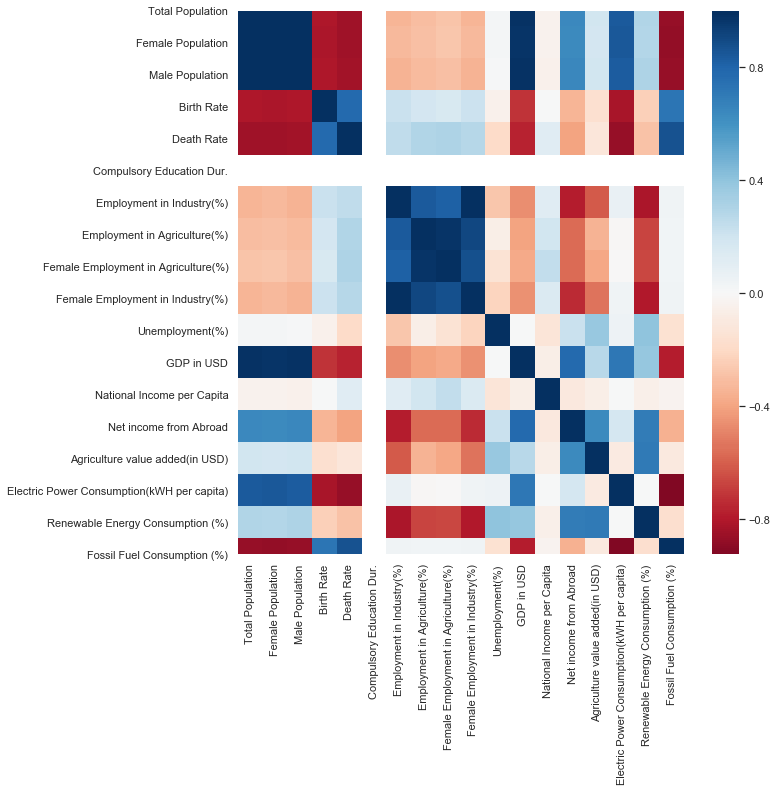

In [121]:
# create a copy
df_cleaned_us_copy=df_cleaned_us.copy()
# Exclude the categorical features from the matrix
df_cleaned_us_copy.drop(['Year', 'Country'], inplace=True, axis='columns')

# plot a correlation matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_cleaned_us_copy.corr(), cmap='RdBu', center=0,ax=ax)
plt.savefig('correlation_us.png')
plt.show()

The above is the correlation matrix between features for USA.
It is found that ***Compulsory Education Duration*** feature does not have any correlation with other features, hence, it can be excluded from our analysis. Also, ***Income per capita*** has a very weak correlation with other features and can be excluded.
I have checked the correlation matrices for each of the countries and found that the fields Income per capita and Compulsory Education Duration have the same kind of correlation with other features. Only one correlation matrix has been included here as an example.

## Analysis Using Plots

### Comparing Population of Countries in 2000 and 2018:

Since we have the data for different countries, we can compare how the population for different countries has changed in 2018 - the most recent year, as opposed to 2000. The following code prepares two DataFrames - one for each year under consideration. We extract the column Total Population. The difference in population has been shown using a **grouped bar** chart.

In [122]:
# refer to the list of countries
list_countries = COUNTRY_LIST
# intialise two dataframes df_00- year 2000, df_18 - year 2018
df_00 = pd.DataFrame()
df_18 = pd.DataFrame()

# for each dataframe in the list of cleaned dataframes
for i,df in enumerate(list_cleaned_df):
    # pick the value of Total Population for year 2000 and 2018
    df_00[list_countries[i]] = df[df['Year'] == 2000]["Total Population"]
    df_18[list_countries[i]] = df[df['Year'] == 2018]["Total Population"]

# The resulting dataframes have the countries as columns and the two rows each for 2000 and 2018
# To be able to draw a grouped bar plot we need the years as columns, hence we take a transpose
df_00 = df_00.T
df_18 = df_18.T

pd.options.display.float_format = '{:,.1f}'.format  # set other global format

# rename the columns to the year
df_00 = df_00.rename(columns={18 : 2000})
df_18 = df_18.rename(columns={0 : 2018})

# join the dataframes for both the years
df_both_years= df_00.join(df_18)

# the index is the Country name, hence we add it as a column into the data frame.
df_both_years['Countries'] = df_both_years.index

# drop the original index
df_both_years.reset_index(drop=True)

print("Data of Total Population for 2000 and 2018 for all countries: ")
display(df_both_years)

Data of Total Population for 2000 and 2018 for all countries: 


,2000,2018,Countries
USA,"282,162,411.0","327,167,434.0",USA
India,"1,056,575,549.0","1,352,617,328.0",India
China,"1,262,645,000.0","1,392,730,000.0",China
Japan,"126,843,000.0","126,529,100.0",Japan
Canada,"30,685,730.0","37,058,856.0",Canada
Great Britain,"58,892,514.0","66,488,991.0",Great Britain
South Africa,"44,967,708.0","57,779,622.0",South Africa


<Figure size 504x360 with 0 Axes>

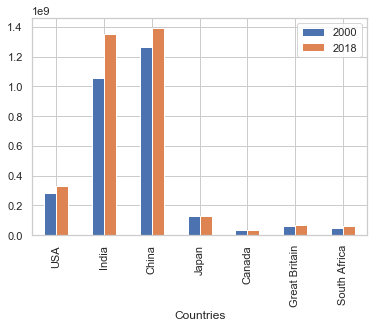

In [123]:
plt.figure(figsize=(7, 5))
# plot the chart using matplotlib.pyplot library
df_both_years.plot(kind='bar',x='Countries',y=[2000, 2018])

We can see that India and China both have the highest population in both the years. However, the increase in population for India in year 2018 is more as compared to the increase in China making their population almost comparable. Canada has the least population amongst all with marginal increase. One striking observation is for Japan - the population is the same in both 2000 and 2018 signifying good population control mechanisms in the country.

### Average Birth Rate and Death Rate for countries across all the years

We have compared the total population in 2000 and 2018 for various countries. Now let us compare the average birth rate and death rate for different countries. Using the combined dataframe that contains the data for all the features for all the countries, we have **grouped the rows by country** and found the mean birth rate and death rate. I have used a bar chart and sorted the countries in descending order of birth rate and death rate.

The following function has been implemented:
* **group_df():** This function takes a column name as a parameter and returns a new DF with the data for countrywise average for the specified feature.
* **plot_bar():** This function takes a dataframe as an argument and plots a bar chart based on the X and Y features

In [124]:
def group_df(feature):
    # create a new dataframe
    df_grouped=pd.DataFrame()

    # find average for each country
    df_grouped['Avg. ' + feature]=combined_df.groupby('Country')[feature].mean()

    # set the index as a column - countries
    df_grouped['Country']=df_grouped.index

    # drop the index
    df_grouped.reset_index(drop=True, inplace=True)

    # sort the rows based of Avg Birth rate
    df_grouped.sort_values('Avg. '+feature, inplace=True, ascending=False)

    print("Avg. " + feature)
    display(df_grouped)
    
    return df_grouped

def plot_bar(df, x_feature, y_feature):
    # bar plot
    plt.figure(figsize=(8, 5))
    sns.set(style="whitegrid")
    ax = sns.barplot(
        data= df,
        x= x_feature,
        y= "Avg. " + y_feature)

Avg. Birth Rate


,Avg. Birth Rate,Country
3,31.3,India
5,30.8,South Africa
1,20.5,China
6,15.7,USA
0,14.7,Canada
2,13.7,Great Britain
4,12.4,Japan


Avg. Death Rate


,Avg. Death Rate,Country
3,12.3,India
5,11.9,South Africa
2,10.9,Great Britain
6,8.7,USA
1,7.6,China
4,7.5,Japan
0,7.2,Canada


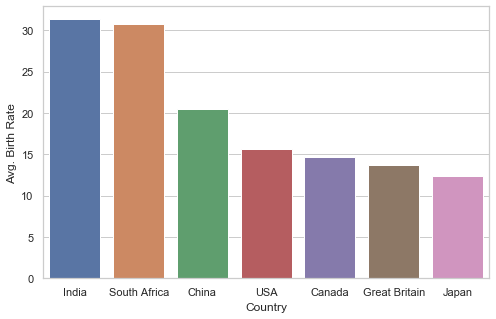

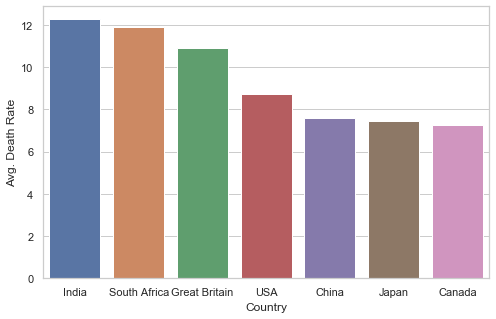

In [125]:
df_birth=group_df('Birth Rate')
plot_bar(df_birth, 'Country', 'Birth Rate')

print("========================================================")
df_death=group_df('Death Rate')
plot_bar(df_death, 'Country', 'Death Rate')

From the above two plots we can see that India has the highest Avg Birth Rate as well as Avg Death Rate which is interesting since it had the second highest population in 2018. Similar is the trend for South Africa which is again surprising since South Africa had a very low population. For China, the Birth Rate is higher than the Death Rate thus leading to the highest population in the world. For Great Britain the Death Rate is much higher than the Average Birth Rate, leading to low population.

### GDP for all countries in the last 10 years

I have used a line chart to show how the GDP for various countries has varied over the last 10 years. We extract the columns Year, GDP in USD and Country from each of the country's dataframe and store it in a smaller dataframe for plotting.
A **line plot** clearly shows the trends over a period of time and can also be used to compare the trends of different categories.

Few records from the Dataframe containing Year, GDP and Country:


,Year,GDP in USD,Country
0,2018,"2,718,732,231,257.6",India
1,2017,"2,652,242,857,923.9",India
2,2016,"2,290,432,075,123.8",India
3,2015,"2,103,587,813,812.8",India
4,2014,"2,039,127,446,298.6",India


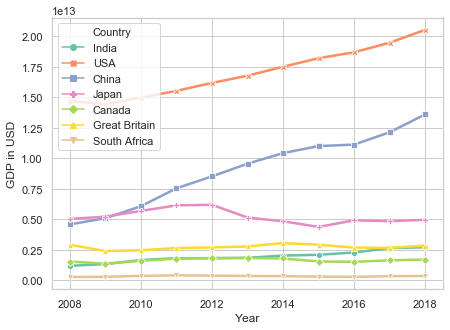

In [126]:
# function to to form a dataframe with Year, GDP and Country
def extract_columns(df_cleaned):
    df=pd.DataFrame()
    # pick data for the recent 10 years, note that the data sorted in descending order of year
    df['Year']=df_cleaned.loc[:10, 'Year']
    df['GDP in USD']=df_cleaned.loc[:10, 'GDP in USD']
    df['Country']=df_cleaned.loc[:10, 'Country']
    return df

# function to fetch a single dataframe with 3 features from each country
def form_gdp_df():
    # function call to extract_columns()
    indf=extract_columns(df_cleaned_in)
    usdf=extract_columns(df_cleaned_us)
    cndf=extract_columns(df_cleaned_cn)
    jpdf=extract_columns(df_cleaned_jp)
    cadf=extract_columns(df_cleaned_ca)
    gbdf=extract_columns(df_cleaned_gb)
    zadf=extract_columns(df_cleaned_za)
    # combine the 7 dfs into a single df with 3 columns
    # we ignore the original index
    gdp_df=pd.concat([indf, usdf, cndf, jpdf, cadf, gbdf, zadf], ignore_index=True)
    return gdp_df

# get the combined DF
gdp_df=form_gdp_df()

print("Few records from the Dataframe containing Year, GDP and Country:")
display(gdp_df.head())

# set figure size
plt.figure(figsize=(7, 5))
sns.set(style="whitegrid")
# plot using seaborn library
ax=sns.lineplot(x='Year', y='GDP in USD', hue='Country', style="Country",palette="Set2", markers=True, dashes=False, data=gdp_df, linewidth=2.5)

We can see that USA has the highest GDP amongst all countries which is clear throughout the years. The GDP for China was low in the year 2008 and shows a significant rise upto 2018 which is attributed to their progress in various fields like manufacturing, however, in comparison to USA, it is still very less.

For Japan, the GDP shows a slight rise upto 2012 which may be due to Japan's growth strategy that was adopted to pull it out from deflation, but thereafter there is a dip in the GDP.

### Electric Power Consumption vs Population for India and China

As seen from the population grouped bar plot above, India and China are the most populated countries. Let us examine the Electric power consumption in these countries. For this task, I have extracted the Population, Country and Electric Power consumption from the dataframes for these two countries and visualised them using a scatter plot.

Few records from the selected features: 


,Total Population,Electric Power Consumption(kWH per capita),Country
0,"1,352,617,328.0",335.2,India
1,"1,338,658,835.0",335.2,India
2,"1,324,509,589.0",335.2,India
3,"1,310,152,403.0",335.2,India
4,"1,295,604,184.0",804.5,India


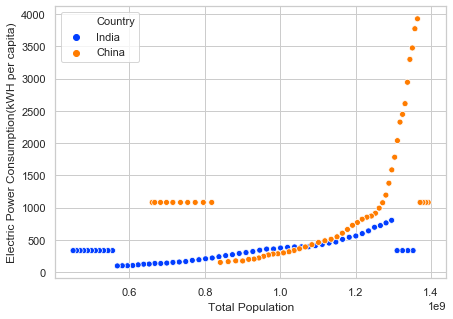

In [127]:
# function to extract specific columns from the DFs for India and China
def form_in_cn_df():
    # for India
    indf=df_cleaned_in[['Total Population', 'Electric Power Consumption(kWH per capita)', 'Country']]
    # for China
    cndf=df_cleaned_cn[['Total Population', 'Electric Power Consumption(kWH per capita)', 'Country']]
    # combine the two dataframes
    in_cn_df=pd.concat([indf, cndf])
    return in_cn_df

# get the desired data
in_cn_df=form_in_cn_df()
print("Few records from the selected features: ")
display(in_cn_df.head())

# scatter plot
plt.figure(figsize=(7, 5))
sns.set(style="whitegrid")
ax=sns.scatterplot(x='Total Population', y='Electric Power Consumption(kWH per capita)', hue='Country', palette="bright", data=in_cn_df)

From the above plot it is clear that with the increase in the population, the electric power consumption is bound to increase. This is evident from the sudden shooting up of the electric power consumption of China. For India there has been a gradual increase in the consumption with population.The constant values in both the lines indicate the mean consumption.

### Total Population vs Electric Power consumption for Canada upto 2015

Canada is a country with very low population. Let us analyse if the population has any effect on the Electrical Energy Consumption in this country upto the year 2015. I have used a single line plot to see the trend with increase in population.

First few records of the data: 


,Electric Power Consumption(kWH per capita),Total Population,Year
3,"13,266.0","35,702,908.0",2015
4,"15,588.5","35,437,435.0",2014
5,"15,750.8","35,082,954.0",2013
6,"15,336.6","34,714,222.0",2012
7,"15,644.5","34,339,328.0",2011


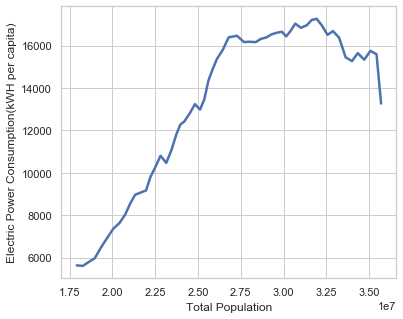

In [128]:
# read the columns from the df for Canada
df=df_cleaned_ca.loc[3:, ['Electric Power Consumption(kWH per capita)','Total Population', 'Year']]

print("First few records of the data: ")
display(df.head())

# line plot
plt.figure(figsize=(6, 5))
sns.set(style="whitegrid")
sns.lineplot(x='Total Population', y='Electric Power Consumption(kWH per capita)', palette="colorblind",data=df, linewidth=2.5)

From the above plot we can observe that for Canada the Electric power consumption has risen constantly with the rise in population. However, it remained constant after a point and thereafter reduced. Although the population in Canada is the least, it has a high electric power consumption which may be due to the extremely lower temperatures in the country.

### Variation in different Energy Consumption over the years for Russia

For this analysis, I have chosen the energy consumption data for Russia over the years upto 2010 and plotted a multi-line chart to observe the trend.

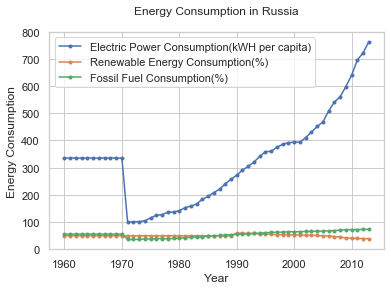

In [129]:
# Pick the columns Year, and 3 different power consumptions from the dataframe for russia
plt.plot(df_cleaned_in.loc[5:, ['Year']],df_cleaned_in.loc[5:, ['Electric Power Consumption(kWH per capita)']],'.-')
plt.plot(df_cleaned_in.loc[5:, ['Year']],df_cleaned_in.loc[5:, ['Renewable Energy Consumption (%)']],'.-')
plt.plot(df_cleaned_in.loc[5:, ['Year']],df_cleaned_in.loc[5:, ['Fossil Fuel Consumption (%)']],'.-')

plt.legend(['Electric Power Consumption(kWH per capita)', 'Renewable Energy Consumption(%)', 'Fossil Fuel Consumption(%)'], loc='best')
plt.title("Energy Consumption in Russia\n")
plt.xlabel('Year')
plt.ylabel('Energy Consumption')
plt.show()

From this plot, it can be observed that The Electric power consumption has increased significantly over time. On the other hand, the consumption for Fossil Fuels and Renewable Energy is low as compared to electrical energy. Fossil Fuel consumption seems to have increased between 2000 and 2010.

### Employment in the Agricultural sector in Countries in the year 2015

Let us examine which country has the most percentage of females employed in Agriculture in the year 2015. For this, I have used extracted Employment in Agriculture column from the DF for each country and displayed the values using a Bar plot.

Employment in Agriculture data for 2015: 


,Employment in Agriculture(%),Countries
1,45.6,India
2,28.6,China
6,5.6,South Africa
3,3.6,Japan
4,1.6,Canada
0,1.4,USA
5,1.1,Great Britain


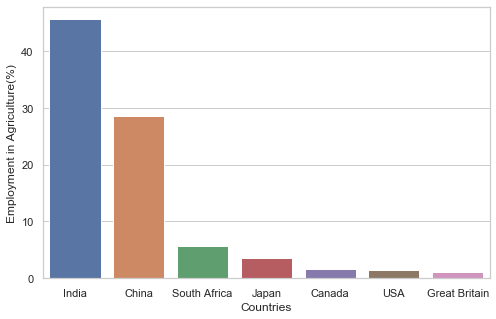

In [130]:
# get the list of countries
list_countries=COUNTRY_LIST

df_agr_emp=pd.DataFrame()

# iterate over the dataframe
for i,df in enumerate(list_cleaned_df):
    # store the % Employment in Agriculture for each country 
    df_agr_emp[list_countries[i]]=df[df['Year'] == 2015]["Employment in Agriculture(%)"]

# take the transpose
df_agr_emp=df_agr_emp.T

pd.options.display.float_format = '{:,.1f}'.format  # set other global format

# since we took a transpose to get countries as the rows, the row index shows the names of the countries.
# Add it as a column in the DF
df_agr_emp['Countries'] = df_agr_emp.index
# drop the index
df_agr_emp.reset_index(drop=True, inplace=True)
# The index for Employment % in agriculture needs to be renamed to the actual column name
df_agr_emp=df_agr_emp.rename(columns={3: "Employment in Agriculture(%)"})

# sort the rows based in decreasing order of % Employment
df_agr_emp.sort_values('Employment in Agriculture(%)', inplace=True, ascending=False)

print("Employment in Agriculture data for 2015: ")
display(df_agr_emp)

# bar plot
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")
ax = sns.barplot(
    data= df_agr_emp,
    x= 'Countries',
    y= 'Employment in Agriculture(%)')

From the above plot it is evident that India has the highest percentage of Employment out of the total employed people in Agriculture. This clearly reflects the fact that India is an agricultural nation and has many food items harvested in the country itself. Followed by India is China. In China there is a shortage of Arable Land and hence farming is very labor intensive. Hence the high percentage of employment in agriculture. The rest of the countries have very less percentage of Employment in agriculture. Great Britain has the least percentage in Agriculture which can be attributed to the fact that it produces less than 60% of the food that is consumed.

# Summary and Conclusion

The World bank dataset consists of a number of features which can be used to develop interesting patterns in the data. I have collected the data for 7 countries for about 20 features. The data was pre-processed to remove columns with too many missing values and fill missing values with the average values for the features. Another way would have been to remove records with missing fields, however, this was not done since the data consists of records for 59 years only (one record per year per country). Hence, removing these values would have resulted in a very small dataset not suitable for analysis. Other efficient techniques can be used to find missing values to enhance the analysis.

Some analysis was done between the Population counts, birth rate and death rate which revealed some interesting patterns about how the birth rate and death rate affect the overall population. Similarly, based on the nature of the countries, it was found that India has highest percentage of Employment in agriculture. Other analyses on the power consumption variation with the total population also showed that electrical power consumption is the highest in most countries which relates to their population.

Further to this, more analysis can be performed on the Employment features such as percentage of males and females in each sector and comparisons can be made across years in different countries.

This analysis can also be used to develop predictive models to predict the population growth based on Birth Rate and Death Rate or GDP growth based on employment. The analysis can be extended in the future by including other features from the API like Arable land, Education, Health services, etc. and make predictions.